In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context='paper', style='whitegrid', rc={'figure.figsize':(8, 5), 'figure.dpi': 120})
color_palette = sns.color_palette("Set2")
sns.set_palette(color_palette)

seed_ = 20200218
np.random.seed(seed_)


import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, RNN, Activation
from keras.optimizers import *

import tensorflow as tf
tf.random.set_seed(seed_)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
df = pd.read_csv("./data/sunspots.csv")

In [3]:
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


### drop first column and rename column

In [4]:
df.drop(columns=[df.columns[0]], axis=1, inplace=True)

In [5]:
df.rename(columns={df.columns[1]: 'monthly_sunspot'}, inplace=True)

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
df.head()

,Date,monthly_sunspot
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252 entries, 0 to 3251
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             3252 non-null   datetime64[ns]
 1   monthly_sunspot  3252 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 50.9 KB


## 
### preprocessing function

In [9]:
def windowing_arr(series, window_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda window: (window[:-1], window[-1:]))
    return ds

def tensor_ds_to_X_Y(tensor_ds):
    X = []
    Y = []
    
    for window in ds:
        x, y = window
        X.append(x.numpy())
        Y.append(y.numpy())
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

#### preprocessing data

In [10]:
window_size = 30
batch_size = 24
shuffle_buffer = 1000

split_time = 2800

sunspot = df['monthly_sunspot']

train = sunspot[:split_time]
dev = sunspot[split_time:]

ds = windowing_arr(train, window_size, shuffle_buffer)
X, Y = tensor_ds_to_X_Y(ds)

ds_dev = windowing_arr(dev, window_size, shuffle_buffer)
X_dev, Y_dev = tensor_ds_to_X_Y(ds_dev)

In [11]:
X = X.reshape(X.shape[0], X.shape[1], -1)
X_dev = X_dev.reshape(X_dev.shape[0], X_dev.shape[1], -1)

## 
### Model

In [12]:
model = Sequential()
model.add(LSTM(1, input_shape=(window_size, 1),  return_sequences=False))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))
model.add(keras.layers.Lambda(lambda x: x*10))

In [13]:
class CustomCallback(keras.callbacks.Callback):
    def __init__(self, n_epoch):
        self.n_epoch = n_epoch
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == 1 or epoch%self.n_epoch == 0:
            print(f"Epoch: {epoch}")
            for key, value in logs.items():
                print(f"{key}: {value:.4f}", end=" \t ")
            print()

In [14]:
optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='mean_absolute_error')

In [15]:
hist = model.fit(X, Y, epochs=250, batch_size=batch_size, validation_data=(X_dev, Y_dev), verbose=0,
                callbacks=[CustomCallback(10)])

Epoch: 0
loss: 79.7129 	 val_loss: 76.1142 	 
Epoch: 1
loss: 73.0168 	 val_loss: 69.9438 	 
Epoch: 10
loss: 30.2478 	 val_loss: 28.8602 	 
Epoch: 20
loss: 21.2672 	 val_loss: 21.0939 	 
Epoch: 30
loss: 19.9707 	 val_loss: 19.2547 	 
Epoch: 40
loss: 19.6014 	 val_loss: 19.6408 	 
Epoch: 50
loss: 19.2678 	 val_loss: 18.6310 	 
Epoch: 60
loss: 19.0051 	 val_loss: 18.3932 	 
Epoch: 70
loss: 19.3818 	 val_loss: 18.6796 	 
Epoch: 80
loss: 19.3086 	 val_loss: 20.6479 	 
Epoch: 90
loss: 19.2595 	 val_loss: 18.5863 	 
Epoch: 100
loss: 19.1023 	 val_loss: 20.4523 	 
Epoch: 110
loss: 19.1144 	 val_loss: 18.3739 	 
Epoch: 120
loss: 18.8767 	 val_loss: 18.9325 	 
Epoch: 130
loss: 19.3705 	 val_loss: 20.4246 	 
Epoch: 140
loss: 19.6694 	 val_loss: 20.2691 	 
Epoch: 150
loss: 18.8925 	 val_loss: 19.2224 	 
Epoch: 160
loss: 19.0078 	 val_loss: 19.6907 	 
Epoch: 170
loss: 18.6767 	 val_loss: 18.6525 	 
Epoch: 180
loss: 18.8438 	 val_loss: 18.5959 	 
Epoch: 190
loss: 19.2573 	 val_loss: 18.3142 	 
Epoch

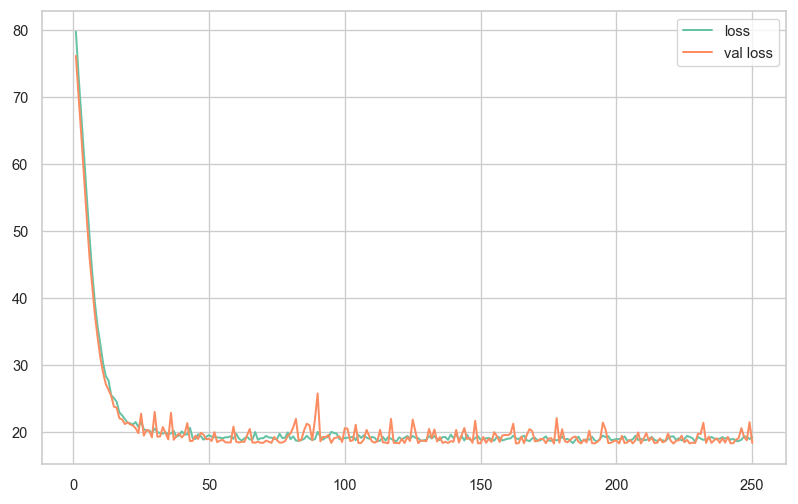

In [16]:
loss = hist.history['loss']
loss_val = hist.history['val_loss']
t = np.arange(1, len(loss)+1)
sns.lineplot(t, loss, label='loss')
t_val = np.arange(1, len(loss_val)+1)
sns.lineplot(t_val, loss_val, label='val loss')

In [17]:
X[0]

array([[ 21.3],
       [ 41.7],
       [ 85.5],
       [ 66.2],
       [ 54.2],
       [107.8],
       [ 55.8],
       [ 62.7],
       [ 86.7],
       [ 81.7],
       [120.5],
       [ 77.3],
       [ 75. ],
       [ 73.3],
       [ 64.5],
       [104.2],
       [ 62.8],
       [ 71.7],
       [ 71.7],
       [ 80.5],
       [ 73.3],
       [ 78. ],
       [ 78.3],
       [ 81.7],
       [ 83.3],
       [ 85. ],
       [118.8],
       [128.7],
       [ 99.5],
       [ 77.2]])

In [18]:
Y[0]

array([95.])

In [19]:
model.predict(np.array([X[0]]))

array([[80.24113]], dtype=float32)

## plot predicted

In [20]:
sample_size = len(sunspot)
sample_size

3252

In [21]:
window_size

30

In [22]:
predicted = []
for time in range(sample_size-window_size):
    x = sunspot[time:time+window_size]
    x = np.array([x])
    x = x.reshape(x.shape[0], x.shape[1], -1)
    predicted.append(model.predict(x))

In [23]:
predicted = np.array(predicted).squeeze()

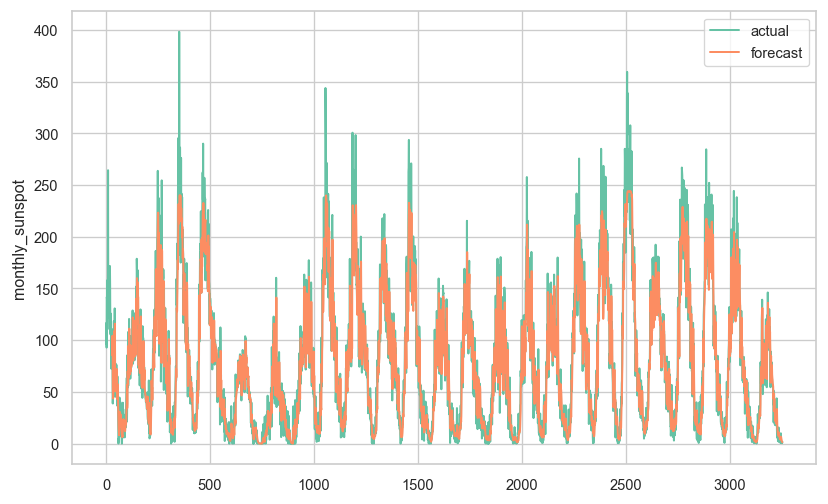

In [24]:
x = np.arange(sample_size)
sns.lineplot(x, sunspot, label='actual')
sns.lineplot(x[window_size:], predicted, label='forecast')

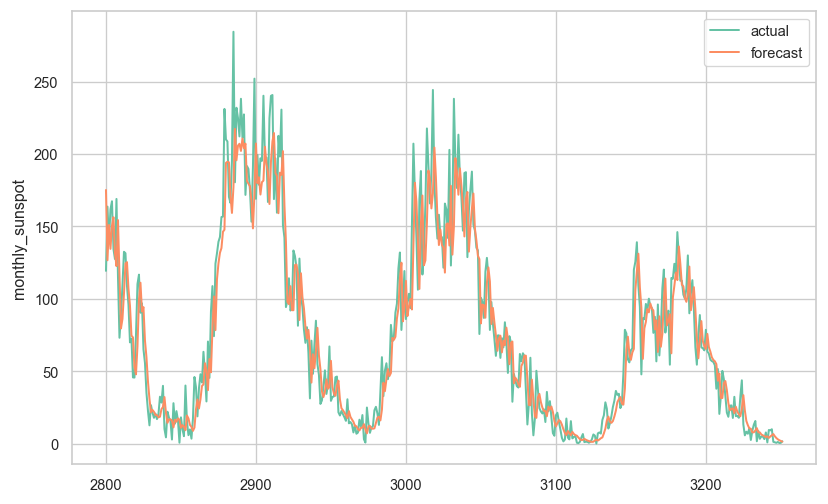

In [25]:
x = np.arange(split_time, sample_size)
sns.lineplot(x, sunspot[split_time:], label='actual')
sns.lineplot(x, predicted[split_time-window_size:], label='forecast')